# Определение легендарного покемона по его характеристикам используя логистическую регрессию

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

dataframe = pd.read_csv(
    "https://raw.githubusercontent.com/YBI-Foundation/Dataset/refs/heads/main/Pokemon.csv",
)

In [79]:
dataframe.head()

,SN,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


### Проверка есть ли пропущенные данные
Можно сделать выводы что отсутствие данных в колонке `Type 2` никак не помешает

In [80]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   SN           800 non-null    int64 
 1   Name         800 non-null    object
 2   Type 1       800 non-null    object
 3   Type 2       414 non-null    object
 4   HP           800 non-null    int64 
 5   Attack       800 non-null    int64 
 6   Defense      800 non-null    int64 
 7   Sp. Attack   800 non-null    int64 
 8   Sp. Defense  800 non-null    int64 
 9   Speed        800 non-null    int64 
 10  Generation   800 non-null    int64 
 11  Legendary    800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


### **Задача.** Выберите бинарную переменную (или сконструируйте из количественной)

Из данного списка можно назначить переменную `Legendary` - `target`

### **Задача.** Выберите несколько объясняющих переменных

Для логистической и линейной регрессии не должно быть мультиколлинеарных переменных. Поэтому необходимо построить матрицу корреляции и посмотреть на переменные.

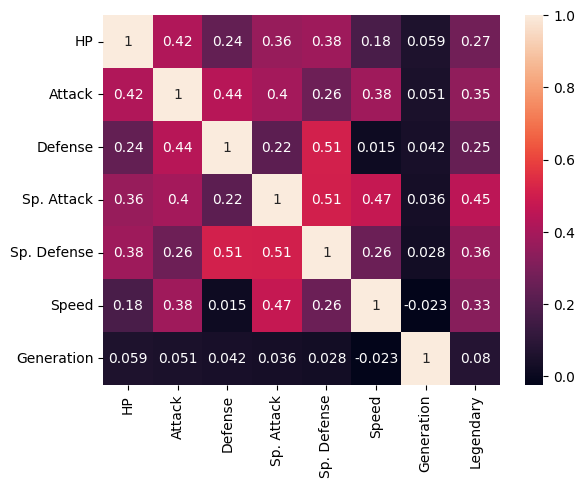

In [81]:
corr = dataframe[["HP", "Attack", "Defense", "Sp. Attack", "Sp. Defense", "Speed", "Generation", "Legendary"]].corr()
clean_corr = corr.drop("Legendary")
sns.heatmap(clean_corr, annot=True)
plt.show()

Исходя из тепловой карты можно сделать следующие выводы:
* сильной корреляции между переменными не наблюдается (>=0.8 или <=-0.8)
* `Generation` - совсем не коррелирует ни с одной из переменной.

### **Задача.** Разделите датасет на обучающую и тестовую выборки

In [82]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_target, test_target = train_test_split(
    dataframe[["HP", "Attack", "Defense", "Sp. Attack", "Sp. Defense", "Speed", "Generation"]],
    dataframe["Legendary"],
    test_size=0.3,
    random_state=42,
    stratify=dataframe["Legendary"],
)

### **Задача.** Обучите модель логистической регрессии на обучающей выборке

In [83]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Нормализация данных
preprocessor = ColumnTransformer(
    transformers=(
        ("number", StandardScaler(), ["HP", "Attack", "Defense", "Sp. Attack", "Sp. Defense", "Speed"]),
        (
            "categorical_not_rank",
            OneHotEncoder(handle_unknown="infrequent_if_exist"),
            ["Generation"],
        ),
    ),
)

model = Pipeline([("preprocessing", preprocessor), ("regressor", LogisticRegression())])

model.fit(train_features, train_target)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=(('number', StandardScaler(),
                                                  ['HP', 'Attack', 'Defense',
                                                   'Sp. Attack', 'Sp. Defense',
                                                   'Speed']),
                                                 ('categorical_not_rank',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['Generation'])))),
                ('regressor', LogisticRegression())])

### **Задача.** Постройте графики recall-precision и roc

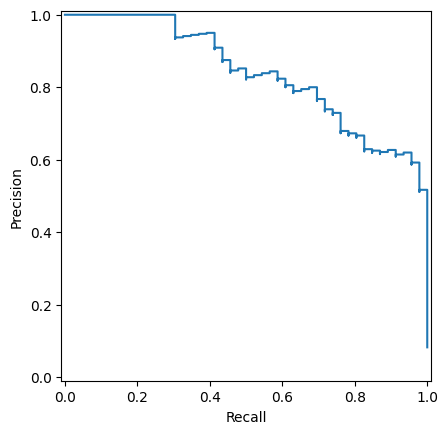

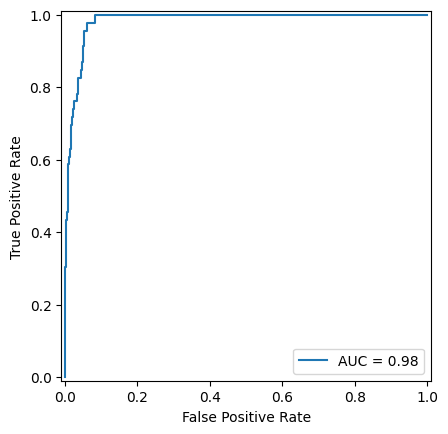

In [84]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, auc, precision_recall_curve, roc_curve

train_predict = model.decision_function(train_features)

prec, recall, _ = precision_recall_curve(train_target, train_predict, pos_label=model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()


fpr, tpr, _ = roc_curve(train_target, train_predict, pos_label=model.classes_[1])
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

### **Задача.** Выберите и обоснуйте порог предсказания Y = 1

In [85]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

metrics_df = pd.DataFrame()
probs = model.predict_proba(train_features)[:, 1]

for threshold in np.linspace(start=0.1, stop=0.9, num=17):
    y_pred = np.where(probs >= threshold, 1, 0)
    df = pd.DataFrame(
        {
            "Accuracy": accuracy_score(train_target, y_pred),
            "Precision": precision_score(train_target, y_pred),
            "Recall": recall_score(train_target, y_pred),
            "F1-score": f1_score(train_target, y_pred),
        },
        index=[threshold],
    )

    metrics_df = pd.concat([metrics_df, df])

metrics_df.T

,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90
Accuracy,0.925000,0.942857,0.948214,0.948214,0.951786,0.951786,0.957143,0.957143,0.957143,0.953571,0.951786,0.950000,0.950000,0.950000,0.948214,0.944643,0.941071
Precision,0.523256,0.594595,0.619718,0.644068,0.672727,0.686275,0.750000,0.789474,0.805556,0.833333,0.827586,0.821429,0.846154,0.875000,0.904762,0.941176,1.000000
Recall,0.978261,0.956522,0.956522,0.826087,0.804348,0.760870,0.717391,0.652174,0.630435,0.543478,0.521739,0.500000,0.478261,0.456522,0.413043,0.347826,0.282609
F1-score,0.681818,0.733333,0.752137,0.723810,0.732673,0.721649,0.733333,0.714286,0.707317,0.657895,0.640000,0.621622,0.611111,0.600000,0.567164,0.507937,0.440678


Для текущей задачи полнота важнее чем точность т. к в целом легендарные покемоны это редкость и лучше определить обычного покемона легендарным. Исходя из таблицы выше лучше выбрать t = 0.20 как компромисс между точностью и полнотой.

### **Задача.** Сделайте предсказания целевой переменной для тестовой выборки

In [86]:
test_probs = model.predict_proba(test_features)[:, 1]
THRESHOLD = 0.2
test_predict = np.where(test_probs >= THRESHOLD, 1, 0)

### Задача. Постройте матрицу ошибок.

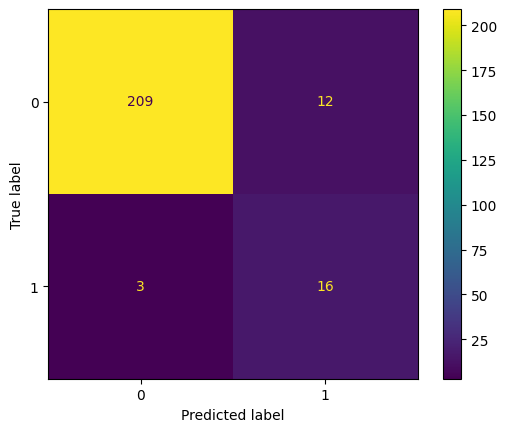

In [87]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

ConfusionMatrixDisplay(confusion_matrix(test_target, test_predict)).plot()

### **Задача.** Рассчитайте метрики качества

In [88]:
from sklearn.metrics import classification_report

print(classification_report(y_true=test_target, y_pred=test_predict))

              precision    recall  f1-score   support

       False       0.99      0.95      0.97       221
        True       0.57      0.84      0.68        19

    accuracy                           0.94       240
   macro avg       0.78      0.89      0.82       240
weighted avg       0.95      0.94      0.94       240



### **Задача.** Сделайте выводы относительно полученной модели, ее качества и полученных зависимостей

Учитывая дисбаланс в классах удалось поймать до **84% легендарных покемонов на тестовой выборке и отсеять до 95% обычных покемонов**. Из всех покемонов которые были предсказаны как легендарные 57% действительно таковыми являются т. е ложноположительных результатов 43%. Данные показатели можно считать очень хорошими для решения этой задачи т. к важно не упустить легендарного покемона и нет ничего страшного в том, что мы случайно поймали обычного.